# Finite Elasticity Part I

Authors: Jack S. Hale, Corrado Maurini.

Uses elements from https://jorgensd.github.io/dolfinx-tutorial/chapter2/hyperelasticity.html by Dokken and Wells under CC-BY 4.0

## Summary

In this notebook we will give an example of solving for the displacement field of a geometrically non-linear bar sagging under its own weight.

## Motivation

<img src="images/mazier_et_al_beam.jpeg" alt="drawing" width="500"/>

The above image shows image shows the *deformed configuration* of an initially straight silicone beam with cylindrical cross-section under its own weight. This material is very soft and quite dense. The resulting rotations and strains are large, so the assumptions made in a geometrically linear elastic model are no longer valid. For sensible predictions we must use the theory of finite elasticity. Source: Mazier et al. https://arxiv.org/abs/2102.13455

## Learning objectives

1. Briefly revisit the equations of non-linear elasticity.
1. Be able to express the Lagrangian functional of a geometrically non-linear elastic body in the Unified Form Language (UFL) of the FEniCS Project.
2. Use the automatic differentiation capabilities to derive symbolic expressions for the residual and Jacobian.
2. Understand and implement basic methods for solving non-linear problems that are available in DOLFINx.
3. See the difference in results between a geometrically linear and non-linear analysis.
4. Be aware of the possible effects and solutions to the problem of numerical volumetric locking.
5. Derive a stress measure automatically and output stresses.

## Possible extensions

1. Change boundary conditions to vertical beam under compression.
1. To a three-dimensional analysis.
2. Displacement-pressure (mixed) formulation to cure numerical locking.

## Implementation

We first import the various modules that we require. So that it is clear where each piece of functionality comes from, we use fully qualified names rather than bringing functions into the local namespace (e.g. `ufl.grad` vs `from ufl import grad; grad(u);`). You may 

In FEniCSx, in contrast with the old FEniCS, the use of `from dolfinx import *` or `from ufl import *` is strongly discouraged.

In [1]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import dolfinx.io

import ufl

from utils import NonlinearPDEProblem

We begin by defining a rectangular mesh and writing it out to an XDMF file.

We will model a clamped beam deformed under its own weight in two dimensions. The beam is a rectangular with length $L$ and square cross section of height $H$.

In [2]:
L = 1.0
H = 0.05
mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, [(0.0, 0.0, 0.0), (L, H, 0.0)], [100, 15])

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "w") as f:
    f.write_mesh(mesh)

V = dolfinx.VectorFunctionSpace(mesh, ("CG", 1))

On the clamped end $x = 0$ we will prescribe Dirichlet boundary conditions $u = u_D = (0, 0, 0)$. The rest of the boundary is traction free.

In [3]:
def left(x):
    #print(x.shape)
    #print(x)
    is_close = np.isclose(x[0], 0.0)
    #print(is_close)
    return is_close

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, left_facets)

u_bc = dolfinx.Function(V)
with u_bc.vector.localForm() as loc:
    loc.set(0.0)
    
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

## Governing equations

In elasticity problems, it is often more natural to specify the Lagrangian energy functional of the system, rather than the residual equation. This is also a natural way to work within the FEniCS Project because the automatic differentiation capabilities can derive the residual and Jacobian symbolically for us.

Consider a hyperelastic body $\Omega$. Our task is to find the displacement field $u: \Omega \to \mathbb{R}^3$ that minimises the total potential energy of the system

$$\min_{u \in V} \Pi(u), $$

where $V$ is a function space that satifies boundary conditions on $\partial \Omega$.

For a hyperelastic system

$$ \Pi(u) = \int_{\Omega} \psi(\varepsilon) \; \mathrm{d}x - \int_{\Omega} b \cdot u \; \mathrm{d}x, $$

where $\psi$ is the *elastic stored energy density* of the system, $\varepsilon$ is a general strain measure (possibly more than one), and $b$ is the body force per unit volume.

The Neo-Hookean model is suitable for modelling elastic bodies made from cross-chained polymers e.g. plastics and rubbers. It can be defined by the following set of equations

$$
F(u) = I + \nabla u, \\
C = F^T F, \\
\mathrm{I}_C = \mathrm{trace}(C), \\
J = \mathrm{det}(C), \\
\psi(J, \mathrm{I}_C) = \frac{\mu}{2}(\mathrm{I}_C - 3) - \mu \ln(J) + \frac{\lambda}{2} \ln(J)^2.
$$

The weight can be modelled by setting:

$$ b = (0, 0, -\rho g),$$

where $\rho$ is the density of the beam and $g$ the acceleration due to gravity.

In [4]:
u = dolfinx.Function(V)

# Identity tensor
d = len(u) # Spatial dimension
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(ufl.grad(u) + I)

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

# Elasticity parameters
# nu is to be adjusted as exercise to observe locking.
E, nu = 1.0E4, 0.3
mu = dolfinx.Constant(mesh, E/(2.0*(1.0 + nu)))
lmbda = dolfinx.Constant(mesh, E*nu/((1.0 + nu)*(1 - 2.0*nu)))

# Body load in undeformed configuration
g, rho = -9.81, 1.0
b = dolfinx.Constant(mesh, [0.0, rho*g])

# Stored strain energy density (compressible neo-Hookean model)
psi = ufl.variable((mu / 2.0) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2.0) * (ufl.ln(J))**2)

# Stored strain energy density (compressible linear Hookean model)
# To be implemented as exercise having been given equations.
# Students should load into Paraview and comment on differences.
#epsilon = ufl.sym(ufl.grad(u))
#psi = mu * ufl.tr(epsilon*epsilon) + lmbda * (ufl.tr(epsilon))**2
#P = ufl.diff(psi, epsilon)

dx = ufl.Measure("dx")

Pi = psi*dx - ufl.inner(b, u)*dx

## Minimisation using Newton's algorithm

Variants of Newton's algorithm is the *de facto* algorithm for solving minimisation problems when we have first and second-order derivatives available. With FEniCS we can calculate these derivatives automatically.

We can write the directional derivative (2) of a functional $\Pi$ at a point $u$ in a direction $v$ as

$$
D_u[\Pi(u)][v] = \frac{\mathrm{d}}{\mathrm{d}\tau} \Pi(u + \tau v)|_{\tau=0}.
$$

We can find one possible minimum (1) when the gradient of the functional $\Pi$ with respect to the displacements $u$ is zero.

$$
F(u; v) = D_u[\Pi(u)][v] = 0 \quad \forall v \in V.
$$

$F(u; v)$ is often called the *residual equation*. Physically it represents the balance of internal and external forces on the elastic body (i.e. Newton's second law) in weak form. The colon $;$ in $F(u; v)$ splits the arguments that are non-linear (here $u$), and the arguments that are linear (here $v$). Because of this splitting $F(u; v)$ is called a *semi-linear form*.

(1) There is no guarantee of a unique (global) minimiser of $F$ for a general hyperelasticity problem.

(2) Gateaux derivative https://en.wikipedia.org/wiki/Gateaux_derivative

Let's calculate the residual using the FEniCS `derivative` function:

In [5]:
F_res = ufl.derivative(Pi, u)

We can get the second derivatives (Jacobian or Hessian (3)) at a point $u$ in a direction $\delta u$ by repeating the derivative procedure

$$
J(u; \delta u, v) := D_{u}[F(u; v)][\delta u]
$$

(3) Whether to call $J$ the Jacobian or Hessian depends on the problem; in some problems it is more natural to specify the residual $F(u; v)$ directly. Then $J(u, v, \delta u)$ is the first derivatives (Jacobian) of the residual $F(u; v)$. In our elasticity problem, $J(u, v, \delta u)$ is the second derivative of the functional $\Pi$, hence Hessian is probably more accurate. In FEniCS-land people usually refer to it as the Jacobian in all cases (hence the variable name `J`).

Let's calculate the symbolic Jacobian using the FEniCS derivative function:

In [6]:
J = ufl.derivative(F_res, u)

As a quick reminder, Newton's method consists of the following steps:

Let $u^0$ be an initial guess to our problem. We seek an approved approximation $u^{K+1}$ through a sequence of $K$ *Newton steps*:

$$u^{k+1} = u^{k} + \delta u^k \quad 0, \ldots, K.$$

where the *Newton increments* $\delta u^k$ can be found by solving the following equation:

$$
J(u^k; \delta u^k, v) = -F(u^k; v) \quad \forall v \in V
$$

$K$ is typically chosen online using a convergence criterion e.g.

$$||F(u^K, v)||_{V^*} < \epsilon$$

where $\epsilon$ is a small parameter. This condition defines when 'we have reached equilbrium'.

DOLFINx has various Newton solvers already built-in, so we don't need to code our own solver.  Here we will use the basic `dolfinx.cpp.nls.NewtonSolver`. In the next session we will see how to use `PETSc.SNES` which has far more advanced options available.

The built-in `NewtonSolver` class works by calling user-defined functions to compute the Jacobian and residual. We have implemented `NonlinearPDE` class in the file `utils.py` that contains these functions.

In [7]:
problem = NonlinearPDEProblem(F_res, J, u, bcs)
solver = dolfinx.cpp.nls.NewtonSolver(MPI.COMM_WORLD)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

# Set non-linear problem for Newton solver
solver.setF(problem.F, problem.b)
solver.setJ(problem.J, problem.A)
solver.set_form(problem.form)

num_its, converged = solver.solve(u.vector)
if converged:
    print(f"Converged in {num_its} iterations.")
else:
    print(f"Not converged.")

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "displacement.xdmf", "w") as f:
    f.write_mesh(mesh)
    f.write_function(u)

Converged in 9 iterations.


## Exercise 1: Computing stresses

The conjugate stress measure $P$ (first Piola-Kirchoff stress) can be computed by differentiating the elastic energy density function with respect to the strain measure $F$.

$$P = \frac{\partial \psi}{\partial F}$$

UFL can compute the for $S$ symbolically using `ufl.diff`. Note that to use `ufl.diff` in this way you must have defined the first argument (`psi`) in terms of a second (`F`) wrapped with `ufl.variable`. Without this, you can only differentiate with respect to `u`.

In [8]:
# First Piola-Kirchhoff Stress
P = ufl.diff(psi, F)

`P` above is a UFL symbolic expression. We need to evaluate it to actually obtain the stresses. One easy way to do this in FEniCS is via projection, which requires the solution of a linear system.

Find $P_h \in T$ such that

$$(P_h, v) = (P(u), v) \quad  \forall v \in T$$

where $P(u)$ is the known as it is a function of the computed displacement $u$, and $(\cdot, \cdot)$ is the $L^2$ inner product. Mathematically $P_h$ is the 'best' approximation to $P(u)$ in the space $T$.

In [9]:
# Solve for stresses
T = dolfinx.TensorFunctionSpace(mesh, ("DG", 0))

s = ufl.TrialFunction(T)
t = ufl.TestFunction(T)

a = ufl.inner(s, t)*dx
L = ufl.inner(P, t)*dx

problem = dolfinx.fem.LinearProblem(a, L)
P_h = problem.solve()

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "stress.xdmf", "w") as f:
    f.write_mesh(mesh)
    f.write_function(P_h)

## Exercise 2: Compare the solutions from a linear strain measure vs non-linear strain measure.

1. Make a duplicate of this notebook and open it.
2. Implement a compressible linear Hookean model using the following equations for the strain measure, energy density and conjugate stress measure (Cauchy stress):

$$
\varepsilon = \tfrac{1}{2} (\nabla u + (\nabla u)^T)\\
\psi = \mu \mathrm{tr} (\varepsilon^2) + \lambda [\mathrm{tr}(\varepsilon)]^2 \\
\sigma = \frac{\partial \psi}{\partial \varepsilon}
$$

3. Modify the output filenames `displacement.xdmf` to e.g. `displacement_linear.xdmf`.
4. Run the original and duplicate notebooks.
5. Compare the deformed configuration from both models in Paraview. What do you observe?

## Exercise 3: Clamp the beam at both ends.

1. Make a duplicate of this notebook. Modify the duplicate so that the beam is clamped at *both* ends.

## Exercise 4: Can you trust FEniCS? The Taylor remainder test.

What if you want to explicitly verify that the assembled numerical residual really is the derivative of the energy density that you specified?

This Taylor remainder test is useful for verifying all types of manual (e.g. by hand) or automatic (e.g. TensorFlow, PyTorch, FEniCS) differentiation. It gives a precise answer to the question 'does my code calculate the correct derivative?'.

The Taylor remainder test starts with the following observation.

Let $\Pi(u)$ be the energy of the system. Take a small perturbation $\delta u$ to $u$ then:

$$
| \Pi(u + h \delta u) - \Pi(u)| \to 0 \; \mathrm{at} \; O(h).
$$

by Taylor's theorem.

In words, if we take $h_1 = 1.0$ and $h_2 = 0.5$ then $h_2/h_1 = 0.5$. Compute the left-hand side of the above equation for $h_1$ and $h_2$, then the error $|\Pi(u) - \Pi(u + h_2 \delta u)|/|\Pi(u) - \Pi(u + h_1 \delta u)|$ should be $0.5$ as well.

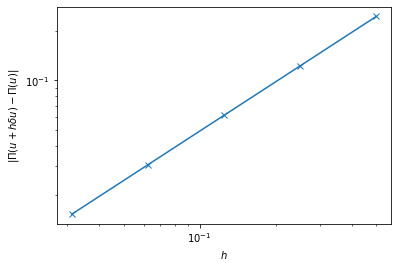

In [10]:
with u.vector.localForm() as loc:
    loc.set(0.5)

s_u = dolfinx.fem.assemble_scalar(Pi)

du = dolfinx.Function(V)
with du.vector.localForm() as loc:
    loc.set(1.0)
    
seed = 0.5
hs = [seed*2**-i for i in range(5)]
errors = []

for h in hs:
    Pi_du = ufl.replace(Pi, {u: u + dolfinx.Constant(mesh, h)*du})
    s_du = dolfinx.fem.assemble_scalar(Pi_du)
    error = np.abs(s_du - s_u)
    errors.append(error)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.xlabel(r"$h$")
plt.ylabel(r"|$\Pi(u + h \delta u) - \Pi(u)|$")
plt.loglog(hs, errors, 'x-')

In [11]:
a, b = np.polyfit(np.log(hs), np.log(errors), 1)
print(a)

1.0000000002613378


By similar arguments, it is possible to show using Taylor's theorem that:

$$
|\Pi(u + h \delta u) - \Pi(u) - h F(u; \delta u) | \to 0 \; \mathrm{at} \; O(h^2).
$$

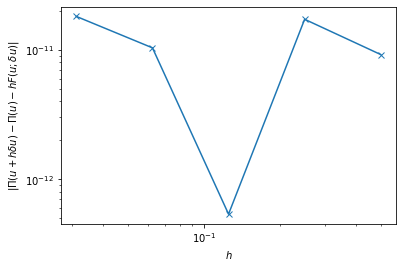

In [12]:
second_order_errors = []
for h in hs:
    Pi_du = ufl.replace(Pi, {u: u + dolfinx.Constant(mesh, h)*du})
    s_du = dolfinx.fem.assemble_scalar(Pi_du)
    
    F_du = dolfinx.fem.assemble_scalar(dolfinx.Constant(mesh, h)*ufl.action(F_res, du))
    
    error = np.abs(s_du - s_u - F_du)
    second_order_errors.append(error)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.xlabel(r"$h$")
plt.ylabel(r"|$\Pi(u + h \delta u) - \Pi(u) - h F(u; \delta u)|$")
plt.loglog(hs, second_order_errors, 'x-')